In [83]:
import pandas as pd
import numpy as np
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

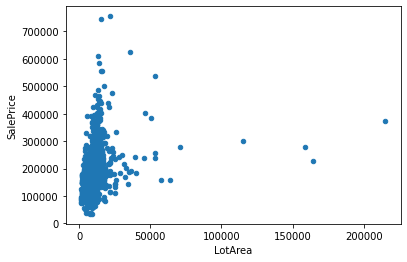

In [84]:
# 分布の確認
train_df.plot.scatter(x="LotArea", y="SalePrice")

In [85]:
# 外れ値の削除（条件内のデータに限定）
train_df = train_df[ train_df["LotArea"]<100000 ]

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

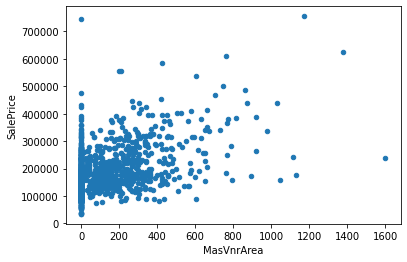

In [86]:
# 分布の確認
train_df.plot.scatter(x="MasVnrArea", y="SalePrice")

In [87]:
# 外れ値の削除（条件内のデータに限定）
train_df = train_df[ train_df["MasVnrArea"]<1200 ]

<AxesSubplot:xlabel='BsmtFinSF2', ylabel='SalePrice'>

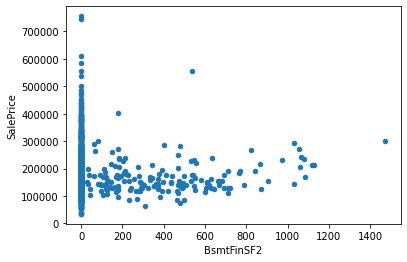

In [88]:
# 分布の確認
train_df.plot.scatter(x="BsmtFinSF2", y="SalePrice")

In [89]:
# 外れ値の削除（条件内のデータに限定）
train_df = train_df[ train_df["BsmtFinSF2"]<1200 ]

In [90]:
# 学習用データとテスト用データの結合
all_df = pd.concat( [train_df, test_df], sort = False )
all_df = all_df.reset_index( drop=True )
# ダミー変数への変換 (object型 → int型)
all_df = pd.get_dummies( all_df )
# 欠損値を平均値で埋める (object型以外)
all_df2 = all_df.fillna( all_df.mean() )
# テストの目的変数を欠損値NaNに戻す
all_df2["SalePrice"] = all_df["SalePrice"]

In [91]:
all_df2["TotalSF"] = all_df2["TotalBsmtSF"] + all_df2["1stFlrSF"] + all_df2["2ndFlrSF"]

<AxesSubplot:xlabel='TotalSF', ylabel='SalePrice'>

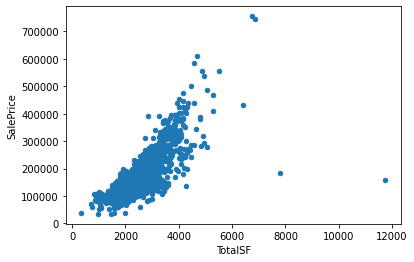

In [92]:
# 分布の確認
all_df2.plot.scatter(x="TotalSF", y="SalePrice")

In [93]:
# 外れ値の削除（条件内のデータに限定）
all_df2 = all_df2[
( all_df2["TotalSF"]<7000 ) |
( all_df2["SalePrice"].isnull() )
]

In [94]:
#プールの有無（広さが0より大きい場合は有）
all_df2['haspool'] = all_df2['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

#２階の有無（広さが0より大きい場合は有）
all_df2['has2ndfloor'] = all_df2['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

#ガレージの有無（広さが0より大きい場合は有）
all_df2['hasgarage'] = all_df2['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

#地下室の有無（広さが0より大きい場合は有）
all_df2['hasbsmt'] = all_df2['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

#暖炉の有無
all_df2['hasfireplace'] = all_df2['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [95]:
# # 築年数 + 最新リフォーム年
# all_df2['Tikunen+rifo']=all_df2['YearBuilt']+all_df2['YearRemodAdd']

In [96]:
# all_df2.plot.scatter(x="Tikunen+rifo", y="SalePrice")

In [97]:
# 一部屋あたりの平均面積 = 建物の総面積 / 部屋数
all_df2['AreaPerRoom'] = all_df2['TotalSF']/all_df2['TotRmsAbvGrd']

<AxesSubplot:xlabel='AreaPerRoom', ylabel='SalePrice'>

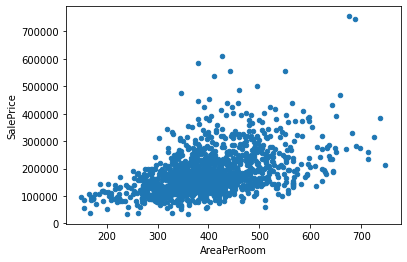

In [98]:
all_df2.plot.scatter(x="AreaPerRoom", y="SalePrice")

In [99]:
# 再び，trainとtestに戻す
train_df_2 = all_df2[ ~all_df2["SalePrice"].isna() ]
test_df_2 = all_df2[ all_df2["SalePrice"].isna() ]
# 説明変数と目的変数の分離 (列を削除)
train_X = train_df_2.drop( ["SalePrice", "Id"], axis=1 )
test_X = test_df_2.drop( ["SalePrice", "Id"], axis=1 )
train_Y = train_df_2["SalePrice"]

In [100]:
# 機械学習の利用 (ランダムフォレスト)
from sklearn.ensemble import RandomForestRegressor
# 学習の設定 (木の数, 評価関数, 乱数の種)
model = RandomForestRegressor( n_estimators=100, criterion='mse',
 max_depth = 10, random_state=1040 )

In [101]:
# スライド4ページの知見より，販売価格にlogを施す【New】
train_logY = np.log( train_Y )

In [102]:
# CV法（クロスバリデーション）
from sklearn.model_selection import cross_val_score
X = train_X # 説明変数
Y = train_logY # 目的変数
scores = cross_val_score( model, X, Y, cv=4 ) # cv: 学習データの分割数
valid_score = np.mean( scores ) # 汎化誤差
print( valid_score )

0.8749328827865879


In [103]:
# # ハイパーPの最適化 (CV法＋グリッドサーチ）
# from sklearn.model_selection import cross_val_score
# X = train_X # 説明変数
# Y = train_logY # 目的変数
# MAX_DEPTH = [10, 20, 30, None] # グリッドサーチの候補
# for depth in MAX_DEPTH:
#  model = RandomForestRegressor( n_estimators=100,
#  criterion='mse', random_state=1080,
#  max_depth = depth
#  )
#  scores = cross_val_score( model, X, Y, cv=4 )
#  valid_score = np.mean( scores )
#  print( valid_score )

In [104]:
# # 機械学習の利用 (勾配ブースティング)
# from sklearn.ensemble import GradientBoostingRegressor
# # ハイパーPの最適化
# from sklearn.model_selection import cross_val_score
# MAX_DEPTH = [1, 2, 3, 4, 5]
# X = train_X # 説明変数
# Y = train_logY # 目的変数
# for depth in MAX_DEPTH:
#  model = GradientBoostingRegressor( n_estimators=100, criterion='mse',
#  random_state=1080, max_depth = depth
#  )
#  scores = cross_val_score( model, X, Y, cv=4 )
#  valid_score = np.mean( scores )
#  print( valid_score )

In [105]:
# 最適化された機械学習モデル（max_depth = 4）
model = GradientBoostingRegressor( n_estimators=100, criterion='mse', random_state=1080, max_depth = 4 )
# 学習データ全体で再学習
model.fit( train_X, train_logY ) 

GradientBoostingRegressor(criterion='mse', max_depth=4, random_state=1080)

In [106]:
# テスト
pred_test_logY = model.predict(test_X)
# logを取り外す変換
pred_test_Y = np.exp( pred_test_logY )
# 予測結果の出力
file = pd.read_csv("sample_submission.csv")
file["SalePrice"] = pred_test_Y
file.to_csv("submission_GB.csv", index=False) 